Currently I'm thinking that while we're studying the various types of sources we would save a version of this notebook which focuses on each fault. 

In [2]:
%matplotlib inline
import os
import json
import codecs
import pickle
import numpy as np
import toolbox as tb
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['lines.linewidth'] = 2

import hmtk.seismicity.max_magnitude as m_max
import openquake.hazardlib.geo.geodetic as geo
import hmtk.sources as src
import hmtk.seismicity.declusterer as decluster
import hmtk.plotting.seismicity.catalogue_plots as cp
import hmtk.plotting.seismicity as sp

from copy import deepcopy
from hmtk.seismicity.completeness.comp_stepp_1971 import Stepp1971
from hmtk.plotting.seismicity.completeness import plot_stepp_1972
import hmtk.seismicity.occurrence as occurrence

from string import Template
from collections import OrderedDict
from hmtk.plotting.mapping import HMTKBaseMap
from hmtk.parsers.catalogue import CsvCatalogueParser
from hmtk.parsers.source_model.nrml04_parser import nrmlSourceModelParser
from hmtk.seismicity.selector import CatalogueSelector

In [3]:
# Marmaris, Turkey
target_lon = 28.25
target_lat = 36.85

sources_file = "../geology/MarmarisDangerousSources15_300km.xml"

catalogue_filename = '../seismicity/Marmaris-catalogue1_homogenised_cleaned.csv'

In [4]:
parser = CsvCatalogueParser(catalogue_filename) # From .csv to hmtk

# Read and process the catalogue content in a variable called "catalogue"
catalogue = parser.read_file() 

print 'Minimum magnitude: ', np.min(catalogue.data['magnitude'])
print 'Maximum magnitude: ', np.max(catalogue.data['magnitude'])
print 'Number of events: ', len(catalogue.data['magnitude'])
print 'Catalogue keys: '
print catalogue.data.keys()

Catalogue Attribute Identifier is not a recognised catalogue key
Minimum magnitude:  1.98
Maximum magnitude:  7.5
Number of events:  30546
Catalogue keys: 
['eventID', 'comment', 'sigmaMagnitude', 'hour', 'SemiMinor90', 'magnitude', 'Agency', 'second', 'longitude', 'month', 'depthError', 'flag', 'depth', 'magnitudeType', 'SemiMajor90', 'timeError', 'year', 'latitude', 'ErrorStrike', 'day', 'minute']


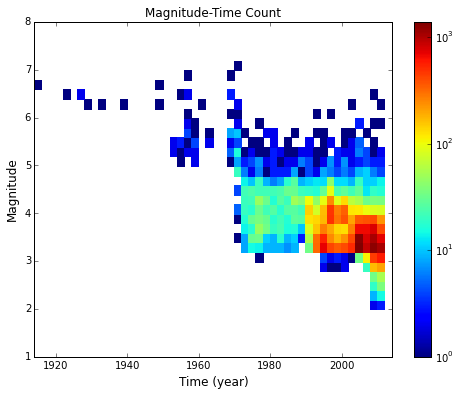

In [5]:
cp.plot_magnitude_time_density(catalogue, 0.2, 2)

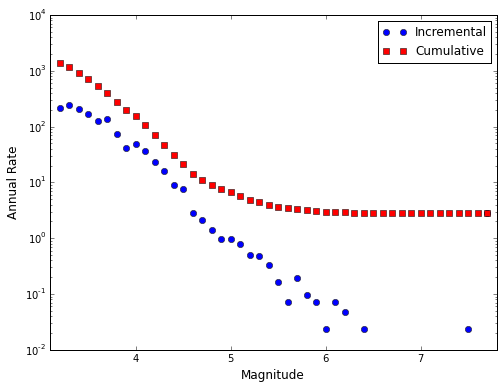

Completeness table guess
[[ 2004.      3.2]
 [ 1994.      4. ]
 [ 1974.      4.6]]


In [6]:
completeness_table_guess = np.array([
        [2004, 3.2],
        [1994, 4.0], 
        [1974, 4.6],
#        [1900, 6.5],
    ]) 
cp.plot_observed_recurrence(catalogue, completeness_table_guess, 0.1)
print 'Completeness table guess'
print completeness_table_guess

In [8]:
# identify clusters
declusterer = decluster.dec_gardner_knopoff.GardnerKnopoffType1()
decluster_config = {
    'time_distance_window': decluster.distance_time_windows.UhrhammerWindow(), 
    'fs_time_prop': 1.0}
cluster_index, cluster_flag = declusterer.decluster(catalogue, decluster_config)

# purge catalogue
declustered = deepcopy(catalogue)
mainshock_flag = cluster_flag == 0 
declustered.purge_catalogue(mainshock_flag)

In [9]:
cm_config = {'number_bootstraps': 500}
cmmax_estimator = m_max.cumulative_moment_release.CumulativeMoment()
cmmax, cmmax_uncertainty = cmmax_estimator.get_mmax(
    declustered, cm_config)
print "Maximum Magnitude (estimate): %.3f +/- %.3f" % (
    cmmax, cmmax_uncertainty)

Maximum Magnitude (estimate): nan +/- nan


In [16]:
# Map configuration
span = 1.5 # deg
map_config = {"min_lon": target_lon - 2*span, 
              "max_lon": target_lon + 2*span, 
              "min_lat": target_lat - span, 
              "max_lat": target_lat + span, "resolution": "l"}

In [17]:
# Reading the models 
parser = nrmlSourceModelParser(sources_file)

# Parse the seismic sources and save them in "source_model"
source_model = parser.read_file("Sources Around Marmaris")

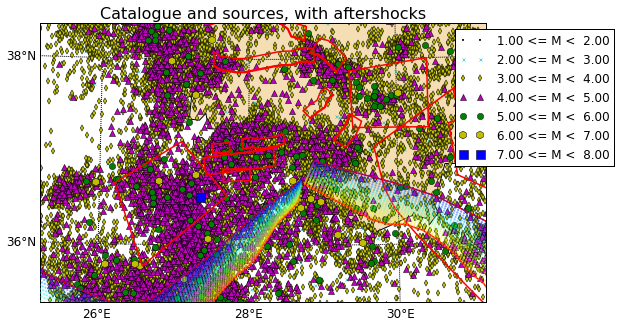

Number of events:  30546


In [18]:
my_map = HMTKBaseMap(map_config, 'Catalogue and sources, with aftershocks')
my_map.add_catalogue(catalogue, overlay=True)
my_map.add_source_model(source_model, area_border='r-', 
                          border_width=1.5, alpha=0.5, overlay=True)
my_map.add_size_scaled_points(target_lon, target_lat, 20, shape='*', 
                                colour='k')
print 'Number of events: ', len(catalogue.data['magnitude'])

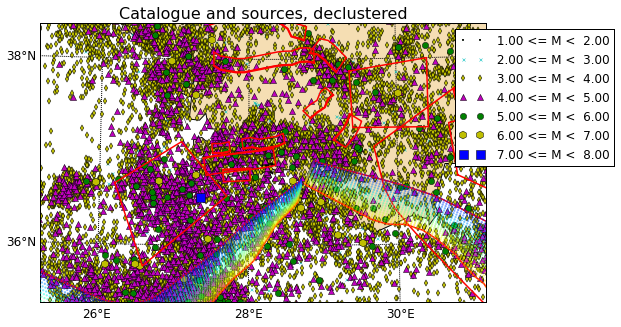

Number of events:  19049


In [19]:
my_map = HMTKBaseMap(map_config, 'Catalogue and sources, declustered')
my_map.add_catalogue(declustered, overlay=True)
my_map.add_source_model(source_model, area_border='r-', 
                          border_width=1.5, alpha=0.5, overlay=True)
my_map.add_size_scaled_points(target_lon, target_lat, 20, shape='*', 
                                colour='k')
print 'Number of events: ', len(declustered.data['magnitude'])

In [20]:
selector = CatalogueSelector(declustered, create_copy=True)
source_ids = [source.id for source in source_model.sources]
print source_ids

['TRCS394', 'TRCS391', 'TRCS331', 'TRCS271', 'TRCS322', 'TRCS393', 'TRCS390', 'TRCS268', 'TRCS913', 'TRCS330', 'HELL001', 'HELL002', 'CYPR001', 'CYPR002', 'AREA001']


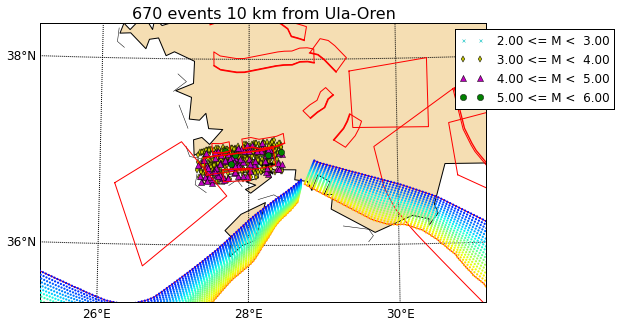

In [34]:
fault_id = 'TRCS913'
r_km = 10
source = [source for source in source_model.sources if source.id == fault_id][0]
source.select_catalogue(selector, r_km)
n_events = source.catalogue.get_number_events()

my_map = HMTKBaseMap(
    map_config, '%d events %d km from %s' % (n_events, r_km, source.name))
my_map.add_catalogue(source.catalogue, overlay=True)
my_map.add_source_model(source_model, area_border='r-', overlay=True)
my_map.add_size_scaled_points(target_lon, target_lat, 20, shape='*', 
                                colour='k')

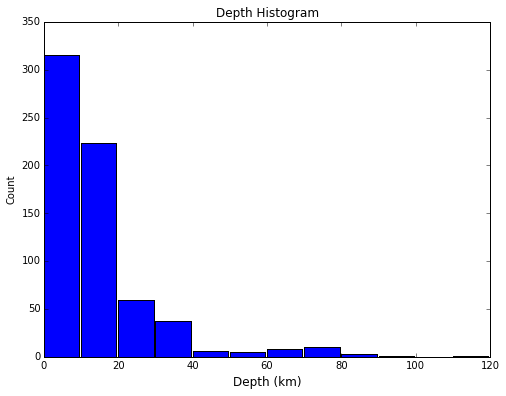

In [36]:
cp.plot_depth_histogram(source.catalogue, 10)

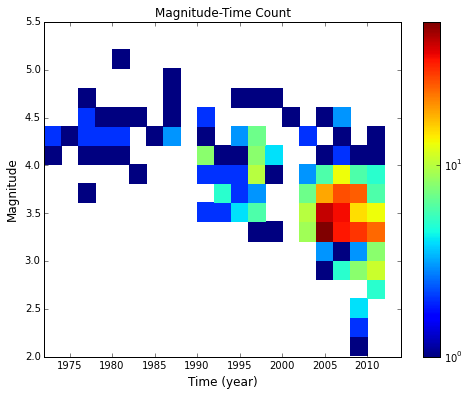

[[ 2004.      3.2]
 [ 1994.      4. ]
 [ 1974.      4.6]]


In [37]:
cp.plot_magnitude_time_density(source.catalogue, 0.2, 2)
print completeness_table_guess

Completeness table using Stepp method (1971)
[[  2.00400000e+03   2.00000000e+00]
 [  1.99900000e+03   3.00000000e+00]
 [  1.97900000e+03   4.00000000e+00]]


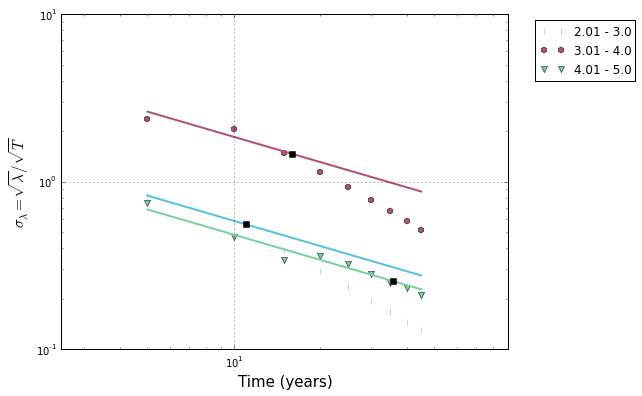

In [38]:
# Set up the configuration parameterss
complete_config = {'magnitude_bin': 1.0, 'time_bin': 5.0, 
               'increment_lock': False}

# Calling the method
completeness_algorithm = Stepp1971()

# Use the catalogue and completeness configuration
completeness_table = completeness_algorithm.completeness(
    source.catalogue, complete_config)

completeness_table = completeness_table[~np.isnan(completeness_table).any(axis=1)]

# Print the completeness table
print 'Completeness table using Stepp method (1971)'
print np.round(completeness_table)

# Setting configuration for the completeness plot
plot_stepp_1972.create_stepp_plot(completeness_algorithm)


In [39]:
fault_file_name = '../geology/Eastern_Mediterranean_Fault_Traces.pkl'
with open(fault_file_name, 'rb') as pickle_stream:
    DATA = pickle.load(pickle_stream)

In [40]:
DATA[fault_id]['statistics']['s_mid']

1.75

In [41]:
# Weichert Method
recurrence1 = occurrence.weichert.Weichert()
weichert_config = {'magnitude_interval': 0.1, 'bvalue': 1., 
                   'itstab': 1e-5, 'maxiter': 1000}
bval1, sigmab1, aval1, sigma1 = recurrence1.calculate(
    source.catalogue, weichert_config, 
    completeness=completeness_table_guess)

print fault_id
print "--- Weichert ---"
print "a-value = %.4f +/- %.4f, b-value = %.4f +/- %.4f" % (
    aval1, sigma1, bval1, sigmab1)

# Weighted Maximum Likelihood Method
recurrence2 = occurrence.b_maximum_likelihood.BMaxLikelihood()
wml_config = {'magnitude_interval': 0.1, 'Average Type': 'Weighted'}
bval2, sigmab2, aval2, sigma2 = recurrence2.calculate(
    source.catalogue, wml_config, 
    completeness=completeness_table_guess)

print "--- Weighted Maximum Likelihood ---"
print "a-value = %.4f +/- %.4f, b-value = %.4f +/- %.4f" % (
    aval2, sigma2, bval2, sigmab2)

TRCS913
--- Weichert ---
a-value = 5.5961 +/- 0.0174, b-value = 1.2484 +/- 0.0403
--- ctime 2004.0  m_c 3.2
--- ctime 1994.0  m_c 4.0
--- ctime 1974.0  m_c 4.6
--- Weighted Maximum Likelihood ---
a-value = 5.6403 +/- 0.2329, b-value = 1.2660 +/- 0.0710


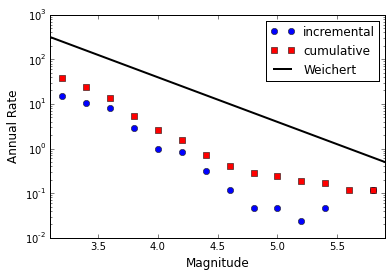

In [42]:
end_year = np.max(source.catalogue.data['year'])
recurrence = cp.get_completeness_adjusted_table(
    source.catalogue, completeness_table_guess, 0.2, end_year)
plt.semilogy(recurrence[:, 0], recurrence[:, 1], 'bo', label='incremental')
plt.semilogy(recurrence[:, 0], recurrence[:, 2], 'rs', label='cumulative')
x_lim = [recurrence[0, 0] - 0.1, recurrence[-1, 0] + 0.1]
plt.xlim(x_lim)
plt.plot(x_lim, 10**(aval1 - bval1*x_lim), 'k-', label='Weichert')
#plt.plot(x_lim, 10**(aval2 - bval2*x_lim), 'g--', label='weighted MLE')
plt.xlabel('Magnitude', fontsize='large')
plt.ylabel('Annual Rate', fontsize='large')
plt.legend()
plt.show()

In [97]:
bins = np.matrix(source_model.sources[0].mfd.get_annual_occurrence_rates())[:,0]
rates = np.zeros((len(bins), len(source_model.sources)))
for i, source in enumerate(source_model.sources):
    rates[:,i] = np.array(source.mfd.get_annual_occurrence_rates())[:,1]

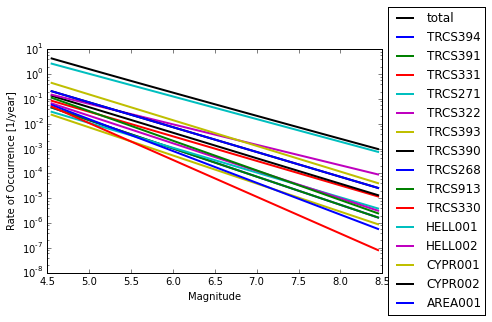

In [156]:
plt.semilogy(bins, rates.sum(1), 'k', label='total')
for rate, label in zip(rates.T, source_ids):
    plt.plot(bins, rate, label=label)
plt.xlabel("Magnitude")
plt.ylabel("Rate of Occurrence [1/year]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [181]:
completeness_table_guess = np.array([
        [2004, 3.2],
        [1994, 4.0], 
        [1974, 4.6],
        [1950, 6.5],
    ]) 
recurrence_fit = occurrence.weichert.Weichert()
b_total, sigma_b_total, a_total, sigma_a_total = recurrence_fit.calculate(
    catalogue, weichert_config, 
    completeness=completeness_table_guess)
recurrence_obs = cp.get_completeness_adjusted_table(
    catalogue, completeness_table_guess, 0.2, end_year)
print "--- Weichert Fit ---"
print "b = %.4f +/- %.4f, a = %.4f +/- %.4f" % (
    b_total, sigma_b_total, a_total, sigma_a_total)

--- Weichert Fit ---
b = 1.1144 +/- 0.0051, a = 6.7683 +/- 0.0027


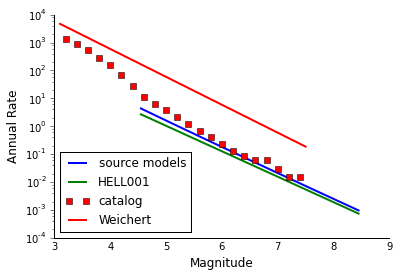

In [192]:
fault_id = 'HELL001'
source = [source for source in source_model.sources if source.id == fault_id][0]

plt.semilogy(bins, rates.sum(1), label='source models')
plt.semilogy(bins, np.array(source.mfd.get_annual_occurrence_rates())[:,1], label=fault_id)

#plt.semilogy(recurrence_obs[:, 0], recurrence_obs[:, 1], 'bo', label='incremental')
plt.semilogy(recurrence_obs[:, 0], recurrence_obs[:, 2], 'rs', label='catalog')
x_lim = [recurrence_obs[0, 0] - 0.1, recurrence_obs[-1, 0] + 0.1]
plt.plot(x_lim, 10**(a_total - b_total*x_lim), label='Weichert')
plt.xlabel('Magnitude', fontsize='large')
plt.ylabel('Annual Rate', fontsize='large')
tb.remove_chartjunk(plt.gca(),['top','right'])
plt.legend(loc='lower left')
plt.show()